<a href="https://colab.research.google.com/github/tajulislamsaidul/Fireball_DataScience_Report.pdf/blob/main/DS_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic statistics:
                 x            y            z    intensity
count  5000.000000  5000.000000  5000.000000  5000.000000
mean      0.007367     0.004517    -0.002105     0.339718
std       0.349281     0.358233     0.492966     0.239505
min      -0.965527    -0.983880    -0.996114     0.000110
25%      -0.196895    -0.199731    -0.400286     0.138014
50%       0.001236     0.004938    -0.005114     0.298940
75%       0.215676     0.216347     0.389797     0.518774
max       0.978027     0.956570     0.985520     0.984666


<Figure size 800x600 with 0 Axes>

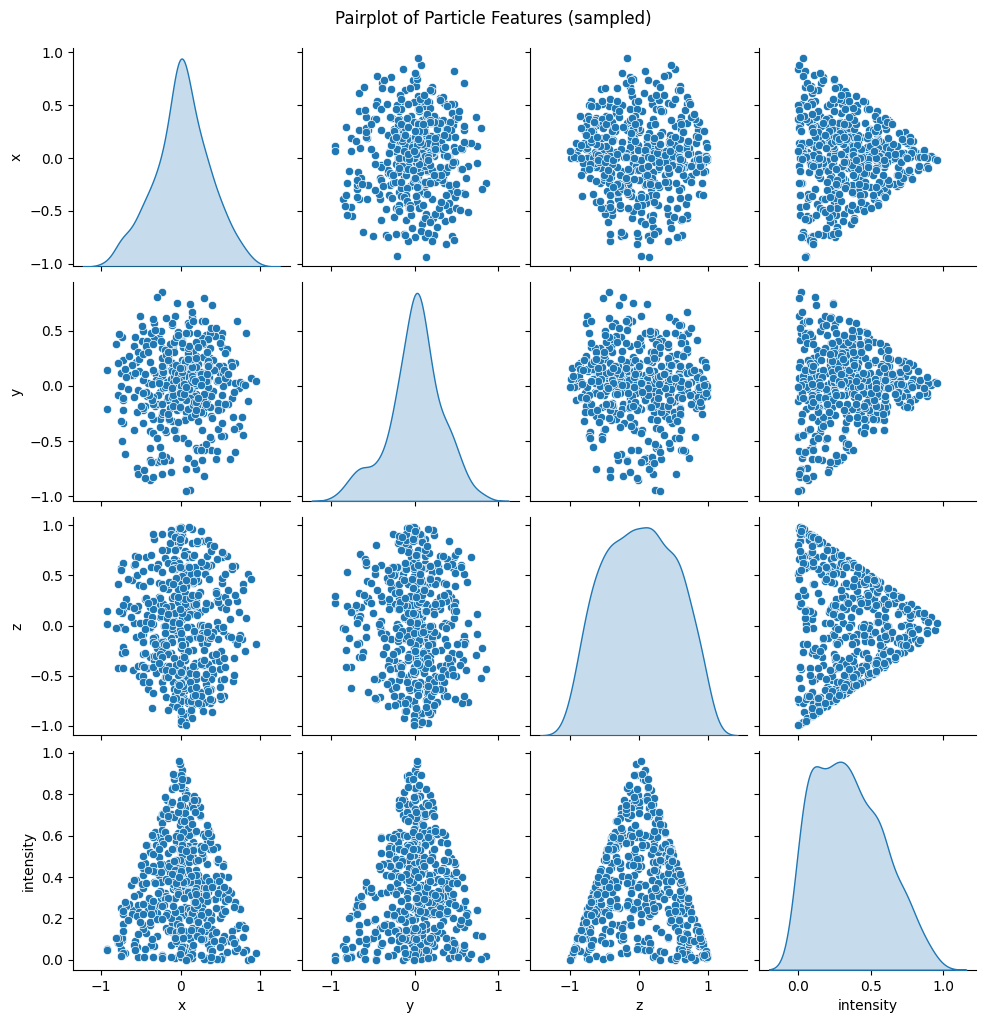

Explained variance ratio by PCA: [0.44173926 0.23333944]


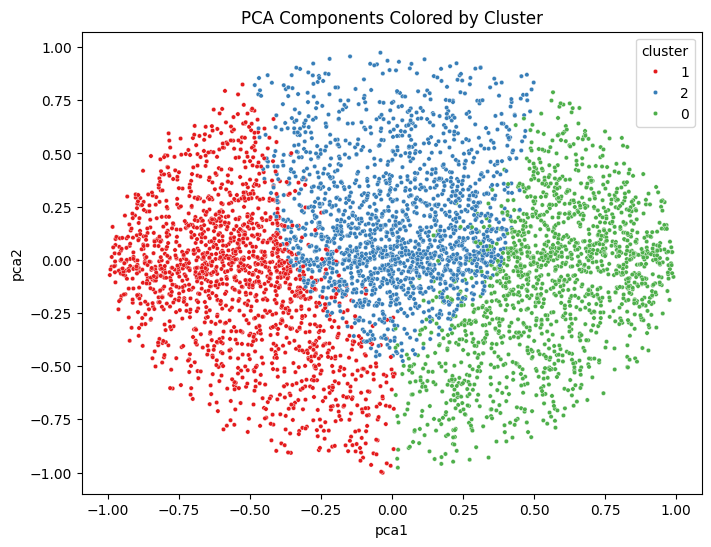

Best params for regression: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Regression Performance (tuned model):
 - MSE: 0.0005
 - R2 Score: 0.9924


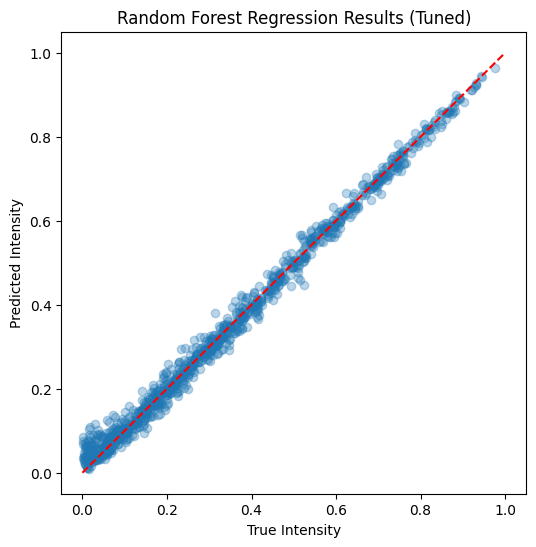

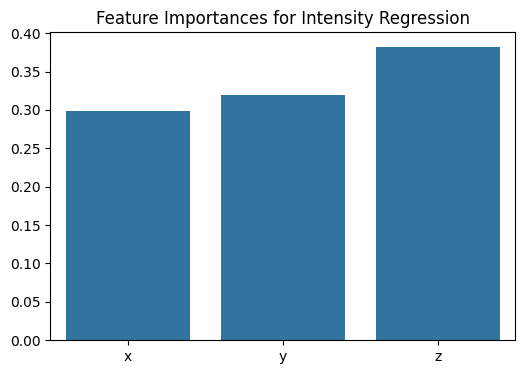

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       297
           1       0.98      0.99      0.98       335
           2       0.97      0.96      0.96       368

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



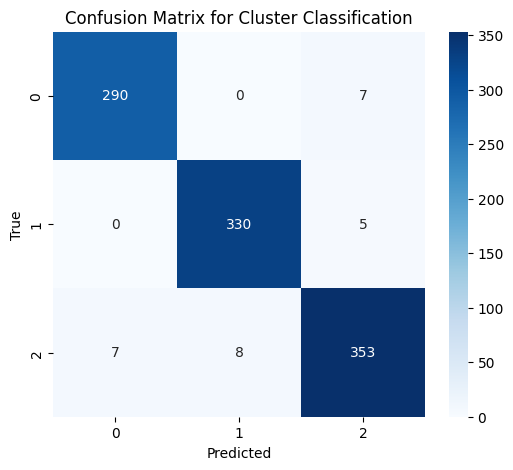

Models saved as rf_regressor_model.joblib and rf_classifier_model.joblib


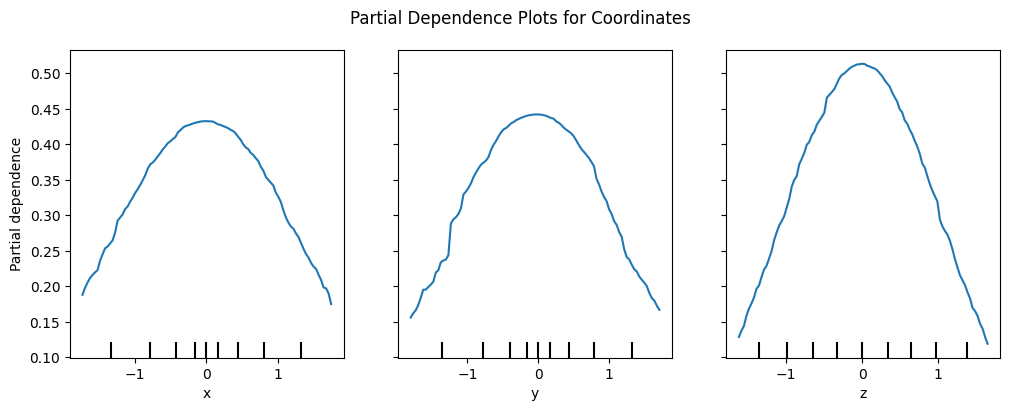

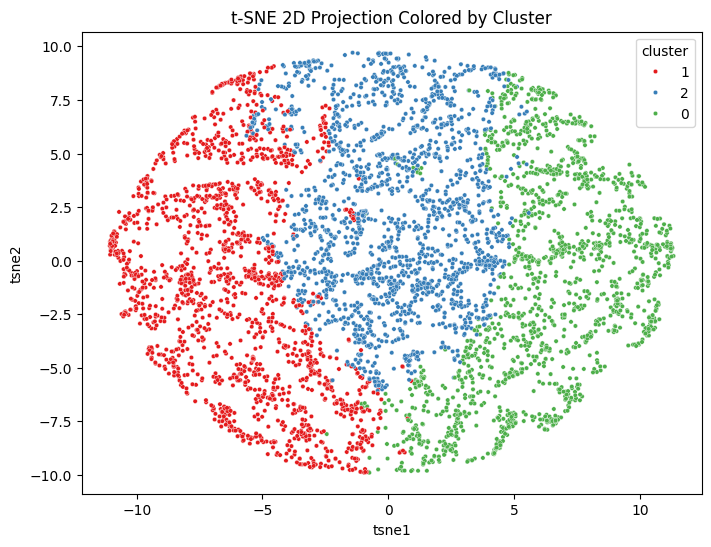

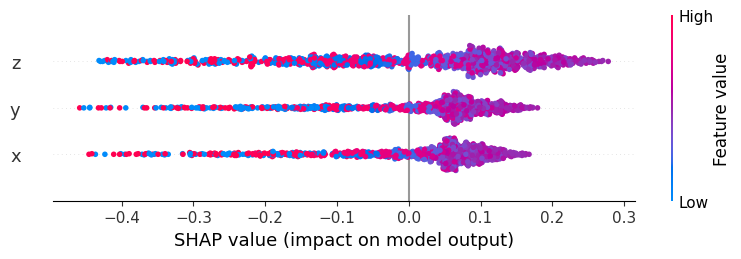

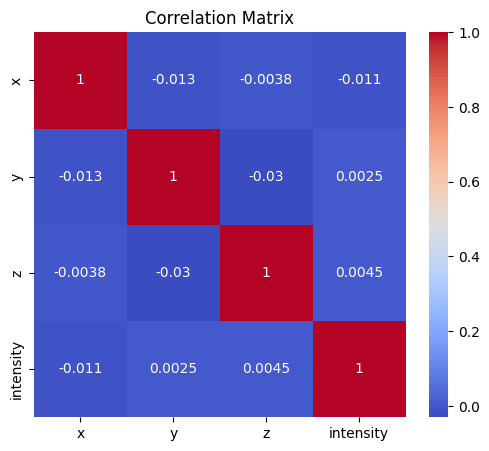

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from sklearn.manifold import TSNE
import plotly.express as px
import joblib
import shap

# Data
n = 5000
r = np.random.rand(n) ** 0.5
theta = np.random.uniform(0, 2 * np.pi, n)
phi = np.random.uniform(0, np.pi, n)
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)
intensity = 1 - r
df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'intensity': intensity})
print("Basic statistics:")
print(df.describe())
plt.figure(figsize=(8,6))
sns.pairplot(df.sample(500), diag_kind='kde')
plt.suptitle("Pairplot of Particle Features (sampled)", y=1.02)
plt.show()
features = df[['x','y','z','intensity']]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1]
print(f"Explained variance ratio by PCA: {pca.explained_variance_ratio_}")
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(features).astype(str)
plt.figure(figsize=(8,6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='Set1', s=10)
plt.title("PCA Components Colored by Cluster")
plt.show()

# Regression
X_reg = df[['x','y','z']]
y_reg = df['intensity']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
rf_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_reg, param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_reg_scaled, y_train_reg)
print(f"Best params for regression: {grid_search.best_params_}")
best_rf_reg = grid_search.best_estimator_
y_pred_reg = best_rf_reg.predict(X_test_reg_scaled)
print("Regression Performance (tuned model):")
print(f" - MSE: {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f" - R2 Score: {r2_score(y_test_reg, y_pred_reg):.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("True Intensity")
plt.ylabel("Predicted Intensity")
plt.title("Random Forest Regression Results (Tuned)")
plt.show()
importances = best_rf_reg.feature_importances_
features_names = ['x', 'y', 'z']
plt.figure(figsize=(6,4))
sns.barplot(x=features_names, y=importances)
plt.title("Feature Importances for Intensity Regression")
plt.show()

# Classification
X_clf = df[['x','y','z']]
y_clf = df['cluster']
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_clf = rf_clf.predict(X_test_clf_scaled)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_clf))
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Cluster Classification")
plt.show()
df['cluster_pred'] = rf_clf.predict(scaler_clf.transform(df[['x','y','z']])).astype(str)

fig_intensity = px.scatter_3d(df, x='x', y='y', z='z', color='intensity',
                             color_continuous_scale='Hot', hover_data=['intensity'],
                             title='Interactive 3D Fireball (Intensity)')
fig_intensity.show()
fig_cluster = px.scatter_3d(df, x='x', y='y', z='z', color='cluster',
                           symbol='cluster_pred',
                           title='Interactive 3D Fireball (Clusters vs Predicted)')
fig_cluster.show()
joblib.dump(best_rf_reg, "rf_regressor_model.joblib")
joblib.dump(rf_clf, "rf_classifier_model.joblib")
print("Models saved as rf_regressor_model.joblib and rf_classifier_model.joblib")

#combining clusters and intensity
fig = px.scatter_3d(
    df,
    x='pca1', y='pca2', z='intensity',
    color='cluster',
    size='intensity',
    hover_data=['x', 'y', 'z'],
    title='3D PCA with Cluster and Intensity'
)
fig.show()
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(best_rf_reg, X_train_reg_scaled, features=[0,1,2], feature_names=['x', 'y', 'z'], ax=ax)
plt.suptitle("Partial Dependence Plots for Coordinates")
plt.show()
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(features)
df['tsne1'] = tsne_result[:, 0]
df['tsne2'] = tsne_result[:, 1]
plt.figure(figsize=(8,6))
sns.scatterplot(x='tsne1', y='tsne2', hue='cluster', data=df, palette='Set1', s=10)
plt.title('t-SNE 2D Projection Colored by Cluster')
plt.show()

#predictions
explainer = shap.TreeExplainer(best_rf_reg)
shap_values = explainer.shap_values(X_test_reg_scaled)
shap.summary_plot(shap_values, X_test_reg, feature_names=['x', 'y', 'z'])
plt.figure(figsize=(6,5))
corr = df[['x','y','z','intensity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()